In [1]:
#fastai study group.  learning to do a competition in Kaggle.
#my code compilation

#11/22/2020 Compile clean draft, based on fastai-2020 study course
#     make it work like 09-tabular
#     no bells no whistles
#    simple: merge features & targets, get lr min recommendation, learn and relearn.
#     expect a score ~.02025

#11/28/2020 Add cross-validation, multilable stratified k-fold
#     from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 
#     src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
#
#     $note tried sklearn 
#     https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
#     UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.

#next: params grid, cross-validation
#next: incorporate non-scoredMultilabelStratifiedKFold

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [6]:
#modeling
from fastai.tabular.all import *


In [2]:
#cross-validation
from ml_stratifiers import MultilabelStratifiedKFold

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [3]:
#src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
def make_folds(folds = 5, random_state = 0, stratify = True, scored = None):
    
    drug = pd.read_csv('../input/lish-moa/train_drug.csv')
    if scored is None:
        scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left')

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc<=18].index.sort_values()
    vc2 = vc.loc[vc>18].index.sort_values()

    # STRATIFY DRUGS 18 OR LESS
    dct1 = {}; dct2 = {}
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)
    
    # STRATIFY DRUGS MORE THAN 18
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)
    
    # ASSIGN FOLDS
    scored['fold'] = np.nan
    scored['fold'] = scored.drug_id.map(dct1)
    scored.loc[scored.fold.isna(),'fold'] = scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
    scored.fold = scored.fold.astype('int8')
    
    return scored[['sig_id','fold']].copy()

## 0. Load Data

In [7]:
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/test_features.csv')]

In [8]:
train_drug = pd.read_csv(path/'train_drug.csv')

print('train drug data\n', train_drug.shape)
display(train_drug.head(3))
train_drug.describe()

train drug data
 (23814, 2)


,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_17efd9558,cacb2b860
freq,1,1866


In [9]:
train_drug['drug_id'].value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
866e7bc56       1
c5ffd58ca       1
d778ccd51       1
d70cdde82       1
98a2c9b21       1
Name: drug_id, Length: 3289, dtype: int64

In [10]:
train_features = pd.read_csv(path/'train_features.csv')
train_targets_scored = pd.read_csv(path/'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(path/'train_targets_nonscored.csv')
test_features = pd.read_csv(path/'test_features.csv')


In [11]:
print('train features', train_features.shape)
print('train targets', train_targets_scored.shape)
print('test features', test_features.shape)

display(train_features.head(3))
display(train_targets_scored.head(3))

train features (23814, 876)
train targets (23814, 207)
test features (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 0.1 EDA

In [12]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


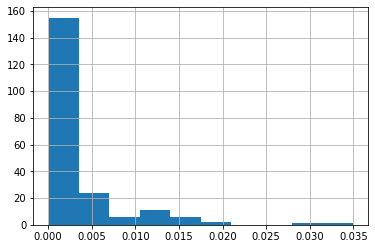

In [13]:
train_targets_scored.iloc[1:].mean().hist()

In [14]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.shape

(3982, 207)

## 1. Data Prep

##### Stratified k-folds
Create X & y  
Note: here y is only used for creating k-folds

In [15]:
X_train = train_features.merge(train_targets_scored,on='sig_id',how='left')
y_train = train_targets_scored
X_train.shape, y_train.shape

((23814, 1082), (23814, 207))

In [16]:
#crossvalidation with stratified k-fold
FOLDS = 10; SEED = 24
skf = make_folds(folds=FOLDS, random_state=SEED, stratify=True, scored=y_train)

X_train['kfold'] = skf.fold.values
X_train.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,4
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,9
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,9
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,7


##### TabularPandas and TabularProc

TabularPandas needs to be told which columns are continuous and which are categorical.  
Note: can handle that automatically using the helper function cont_cat_split (not used here).

In [17]:
#handpick 
cat_names = L(list(train_features.columns[1:4])
cont_names = L(list(train_features.columns[4:]))
cat_names, cont_names

((#3) ['cp_type','cp_time','cp_dose'],
 (#872) ['g-0','g-1','g-2','g-3','g-4','g-5','g-6','g-7','g-8','g-9'...])

In [18]:
#$ac scored_cols = list(train_targets_scored.columns[1:])
#$ac y_names = scored_cols
dep_var = list(train_targets_scored.columns[1:])
dep_var[:10]


['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist']

## 2. Model

Define dls

In [21]:
procs = [FillMissing, Categorify, Normalize]
def get_data(fold):
    val_idx = X_train[X_train['kfold']==fold].index
    #print(val_idx.shape)
    dls = TabularDataLoaders.from_df(X_train, path=path, y_names=dep_var,
                                        cat_names = cat_names,
                                        cont_names = cont_names,
                                        procs = procs,
                                        valid_idx=val_idx,
                                        bs=64)
    return dls #class fastai.tabular.data.TabularDataLoaders

Train k-folds

0


0.002512


epoch,train_loss,valid_loss,time
0,0.020175,0.018340,00:05
1,0.016969,0.017112,00:05
2,0.015119,0.016848,00:05
3,0.013342,0.017478,00:05
4,0.010228,0.018711,00:05
5,0.006800,0.020442,00:05
6,0.004178,0.021318,00:05
7,0.003187,0.021551,00:05


Better model found at epoch 0 with valid_loss value: 0.0183403417468071.
Better model found at epoch 1 with valid_loss value: 0.017112301662564278.
Better model found at epoch 2 with valid_loss value: 0.01684807799756527.


epoch,train_loss,valid_loss,time
0,0.012047,0.016442,00:05
1,0.011680,0.016343,00:05
2,0.011274,0.016415,00:05
3,0.010874,0.016460,00:05
4,0.010990,0.016421,00:05


Better model found at epoch 0 with valid_loss value: 0.016441693529486656.
Better model found at epoch 1 with valid_loss value: 0.016343336552381516.


epoch,train_loss,valid_loss,time
0,0.011570,0.016358,00:05
1,0.011137,0.016360,00:05
2,0.011211,0.016355,00:05
3,0.011136,0.016335,00:05
4,0.011225,0.016370,00:05


Better model found at epoch 0 with valid_loss value: 0.016357803717255592.
Better model found at epoch 2 with valid_loss value: 0.0163554847240448.
Better model found at epoch 3 with valid_loss value: 0.01633511669933796.
1


0.002089


epoch,train_loss,valid_loss,time
0,0.020798,0.019217,00:05
1,0.016847,0.017642,00:05
2,0.015443,0.017681,00:05
3,0.013234,0.017931,00:05
4,0.010128,0.019242,00:05
5,0.006886,0.020852,00:05
6,0.004478,0.021873,00:06
7,0.003538,0.022190,00:05


Better model found at epoch 0 with valid_loss value: 0.019216760993003845.
Better model found at epoch 1 with valid_loss value: 0.017641931772232056.


epoch,train_loss,valid_loss,time
0,0.014511,0.016922,00:05
1,0.014106,0.016807,00:05
2,0.013500,0.016795,00:05
3,0.013170,0.016798,00:05
4,0.013275,0.016808,00:05


Better model found at epoch 0 with valid_loss value: 0.01692151464521885.
Better model found at epoch 1 with valid_loss value: 0.016807379201054573.
Better model found at epoch 2 with valid_loss value: 0.016795096918940544.


epoch,train_loss,valid_loss,time
0,0.013118,0.016795,00:05
1,0.012939,0.016801,00:05
2,0.013110,0.016791,00:05
3,0.013544,0.016810,00:05
4,0.013152,0.016814,00:05


Better model found at epoch 0 with valid_loss value: 0.016794750466942787.
Better model found at epoch 2 with valid_loss value: 0.016791438683867455.
2


0.002089


epoch,train_loss,valid_loss,time
0,0.020988,0.018721,00:05
1,0.016799,0.017109,00:05
2,0.014984,0.016864,00:05
3,0.012964,0.017452,00:05
4,0.010327,0.018169,00:05
5,0.007072,0.019687,00:05
6,0.004709,0.020609,00:05
7,0.003584,0.020916,00:06


Better model found at epoch 0 with valid_loss value: 0.01872112601995468.
Better model found at epoch 1 with valid_loss value: 0.01710917241871357.
Better model found at epoch 2 with valid_loss value: 0.016864046454429626.


epoch,train_loss,valid_loss,time
0,0.012341,0.016370,00:05
1,0.011773,0.016336,00:05
2,0.011337,0.016361,00:05
3,0.011099,0.016386,00:05
4,0.010965,0.016365,00:05


Better model found at epoch 0 with valid_loss value: 0.01636970229446888.
Better model found at epoch 1 with valid_loss value: 0.01633628085255623.


epoch,train_loss,valid_loss,time
0,0.011298,0.016334,00:05
1,0.011368,0.016345,00:05
2,0.011384,0.016321,00:05
3,0.011144,0.016324,00:05
4,0.011250,0.016350,00:05


Better model found at epoch 0 with valid_loss value: 0.01633436419069767.
Better model found at epoch 2 with valid_loss value: 0.016321059316396713.
3


0.001738


epoch,train_loss,valid_loss,time
0,0.021704,0.019081,00:06
1,0.016326,0.017327,00:05
2,0.014988,0.017210,00:05
3,0.013060,0.017586,00:05
4,0.010339,0.018674,00:05
5,0.007432,0.019687,00:05
6,0.005331,0.020543,00:05
7,0.004203,0.020941,00:05


Better model found at epoch 0 with valid_loss value: 0.01908086985349655.
Better model found at epoch 1 with valid_loss value: 0.01732710935175419.
Better model found at epoch 2 with valid_loss value: 0.01721005141735077.


epoch,train_loss,valid_loss,time
0,0.012143,0.016639,00:05
1,0.011698,0.016673,00:05
2,0.011401,0.016800,00:05
3,0.011309,0.016830,00:05
4,0.010983,0.016835,00:05


Better model found at epoch 0 with valid_loss value: 0.016639331355690956.


epoch,train_loss,valid_loss,time
0,0.011732,0.016648,00:05
1,0.012093,0.016637,00:05
2,0.011774,0.016611,00:05
3,0.011879,0.016639,00:05
4,0.011715,0.016644,00:05


Better model found at epoch 0 with valid_loss value: 0.016647813841700554.
Better model found at epoch 1 with valid_loss value: 0.01663711853325367.
Better model found at epoch 2 with valid_loss value: 0.016611410304903984.
4


0.002089


epoch,train_loss,valid_loss,time
0,0.021230,0.019273,00:05
1,0.017038,0.017836,00:05
2,0.015293,0.017599,00:05
3,0.012996,0.017927,00:05
4,0.010159,0.018970,00:05
5,0.006869,0.020554,00:05
6,0.004428,0.021330,00:05
7,0.003418,0.021580,00:05


Better model found at epoch 0 with valid_loss value: 0.019273051992058754.
Better model found at epoch 1 with valid_loss value: 0.017835723236203194.
Better model found at epoch 2 with valid_loss value: 0.017599210143089294.


epoch,train_loss,valid_loss,time
0,0.012364,0.016934,00:05
1,0.011759,0.016970,00:05
2,0.011375,0.017052,00:05
3,0.011128,0.017099,00:05
4,0.010924,0.017060,00:05


Better model found at epoch 0 with valid_loss value: 0.016933592036366463.


epoch,train_loss,valid_loss,time
0,0.011946,0.016976,00:05
1,0.012011,0.016928,00:05
2,0.011964,0.016965,00:05
3,0.011725,0.016928,00:05
4,0.011864,0.016931,00:05


Better model found at epoch 0 with valid_loss value: 0.01697615161538124.
Better model found at epoch 1 with valid_loss value: 0.016927633434534073.
Better model found at epoch 3 with valid_loss value: 0.016927549615502357.
5


0.002089


epoch,train_loss,valid_loss,time
0,0.020963,0.017743,00:05
1,0.017072,0.016629,00:06
2,0.014950,0.016357,00:05
3,0.013134,0.016530,00:05
4,0.010281,0.017577,00:05
5,0.007061,0.019102,00:05
6,0.004574,0.019964,00:05
7,0.003508,0.020250,00:05


Better model found at epoch 0 with valid_loss value: 0.017742831259965897.
Better model found at epoch 1 with valid_loss value: 0.016628600656986237.
Better model found at epoch 2 with valid_loss value: 0.01635690964758396.


epoch,train_loss,valid_loss,time
0,0.012529,0.015773,00:05
1,0.011694,0.015690,00:05
2,0.011315,0.015716,00:05
3,0.011132,0.015743,00:05
4,0.010735,0.015709,00:05


Better model found at epoch 0 with valid_loss value: 0.01577330194413662.
Better model found at epoch 1 with valid_loss value: 0.01568952202796936.


epoch,train_loss,valid_loss,time
0,0.011468,0.015666,00:05
1,0.011584,0.015681,00:05
2,0.011612,0.015640,00:05
3,0.011489,0.015678,00:05
4,0.011462,0.015667,00:05


Better model found at epoch 0 with valid_loss value: 0.015666143968701363.
Better model found at epoch 2 with valid_loss value: 0.01564045622944832.
6


0.002089


epoch,train_loss,valid_loss,time
0,0.020777,0.018664,00:05
1,0.016964,0.016967,00:05
2,0.015390,0.016574,00:06
3,0.013163,0.017086,00:05
4,0.010038,0.018411,00:05
5,0.007114,0.019807,00:05
6,0.004429,0.020641,00:05
7,0.003337,0.020961,00:05


Better model found at epoch 0 with valid_loss value: 0.0186636783182621.
Better model found at epoch 1 with valid_loss value: 0.0169671718031168.
Better model found at epoch 2 with valid_loss value: 0.016574205830693245.


epoch,train_loss,valid_loss,time
0,0.012354,0.016050,00:05
1,0.011851,0.015988,00:05
2,0.011472,0.016143,00:05
3,0.010979,0.016136,00:05
4,0.011031,0.016155,00:05


Better model found at epoch 0 with valid_loss value: 0.01604982279241085.
Better model found at epoch 1 with valid_loss value: 0.015987642109394073.


epoch,train_loss,valid_loss,time
0,0.011213,0.016040,00:05
1,0.011554,0.016013,00:05
2,0.011341,0.016059,00:05
3,0.011249,0.016015,00:05
4,0.011256,0.016048,00:05


Better model found at epoch 0 with valid_loss value: 0.01603950560092926.
Better model found at epoch 1 with valid_loss value: 0.016012703999876976.
7


0.002089


epoch,train_loss,valid_loss,time
0,0.021071,0.018539,00:05
1,0.017000,0.017480,00:05
2,0.015172,0.016798,00:05
3,0.012976,0.017365,00:05
4,0.010268,0.018358,00:05
5,0.007202,0.019769,00:05
6,0.004785,0.020926,00:05
7,0.003706,0.021245,00:05


Better model found at epoch 0 with valid_loss value: 0.018539423123002052.
Better model found at epoch 1 with valid_loss value: 0.017480453476309776.
Better model found at epoch 2 with valid_loss value: 0.016797583550214767.


epoch,train_loss,valid_loss,time
0,0.012266,0.016469,00:05
1,0.011737,0.016475,00:05
2,0.011399,0.016523,00:05
3,0.011203,0.016594,00:05
4,0.011010,0.016592,00:05


Better model found at epoch 0 with valid_loss value: 0.016469191759824753.


epoch,train_loss,valid_loss,time
0,0.011890,0.016480,00:05
1,0.012104,0.016466,00:05
2,0.011809,0.016460,00:05
3,0.011759,0.016456,00:05
4,0.011688,0.016460,00:05


Better model found at epoch 0 with valid_loss value: 0.01648048870265484.
Better model found at epoch 1 with valid_loss value: 0.016466159373521805.
Better model found at epoch 2 with valid_loss value: 0.016459502279758453.
Better model found at epoch 3 with valid_loss value: 0.016455721110105515.
8


0.002089


epoch,train_loss,valid_loss,time
0,0.021246,0.018513,00:05
1,0.017181,0.017217,00:05
2,0.015170,0.017070,00:04
3,0.013366,0.017475,00:05
4,0.010272,0.018797,00:05
5,0.007273,0.020267,00:06
6,0.004826,0.021130,00:05
7,0.003761,0.021591,00:05


Better model found at epoch 0 with valid_loss value: 0.01851295866072178.
Better model found at epoch 1 with valid_loss value: 0.017217138782143593.
Better model found at epoch 2 with valid_loss value: 0.01707037352025509.


epoch,train_loss,valid_loss,time
0,0.012312,0.016587,00:04
1,0.011467,0.016595,00:05
2,0.011303,0.016597,00:05
3,0.011036,0.016654,00:05
4,0.010853,0.016661,00:05


Better model found at epoch 0 with valid_loss value: 0.016586508601903915.


epoch,train_loss,valid_loss,time
0,0.012099,0.016613,00:05
1,0.011824,0.016569,00:05
2,0.011879,0.016568,00:05
3,0.011944,0.016549,00:05
4,0.011966,0.016563,00:05


Better model found at epoch 0 with valid_loss value: 0.016613122075796127.
Better model found at epoch 1 with valid_loss value: 0.016568537801504135.
Better model found at epoch 2 with valid_loss value: 0.016567593440413475.
Better model found at epoch 3 with valid_loss value: 0.016549410298466682.
9


0.002089


epoch,train_loss,valid_loss,time
0,0.021129,0.019076,00:05
1,0.016740,0.017872,00:05
2,0.015060,0.017583,00:05
3,0.012878,0.017955,00:05
4,0.010281,0.019175,00:05
5,0.007005,0.020627,00:05
6,0.004802,0.021774,00:04
7,0.003609,0.022055,00:05


Better model found at epoch 0 with valid_loss value: 0.019076364114880562.
Better model found at epoch 1 with valid_loss value: 0.017871689051389694.
Better model found at epoch 2 with valid_loss value: 0.017582779750227928.


epoch,train_loss,valid_loss,time
0,0.012297,0.016947,00:05
1,0.011724,0.016987,00:05
2,0.011310,0.017079,00:04
3,0.011335,0.017078,00:05
4,0.010865,0.017112,00:04


Better model found at epoch 0 with valid_loss value: 0.016946613788604736.


epoch,train_loss,valid_loss,time
0,0.011964,0.016973,00:05
1,0.011865,0.016941,00:05
2,0.012113,0.016954,00:05
3,0.011856,0.016953,00:05
4,0.011881,0.016929,00:05


Better model found at epoch 0 with valid_loss value: 0.01697288267314434.
Better model found at epoch 1 with valid_loss value: 0.016941173002123833.
Better model found at epoch 4 with valid_loss value: 0.01692884974181652.


[0.01633511669933796,
 0.016791438683867455,
 0.016321059316396713,
 0.016611410304903984,
 0.016927549615502357,
 0.01564045622944832,
 0.016012703999876976,
 0.016455721110105515,
 0.016549410298466682,
 0.01692884974181652]

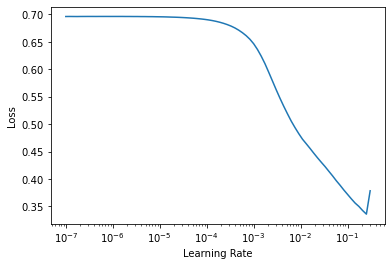

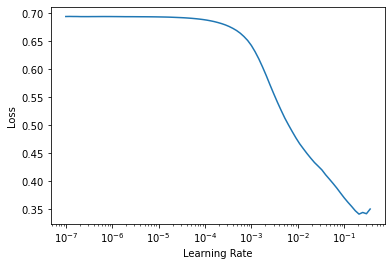

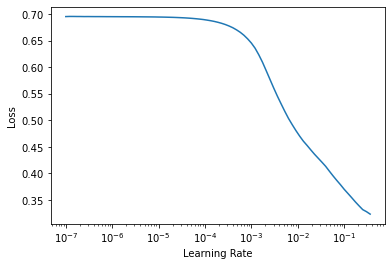

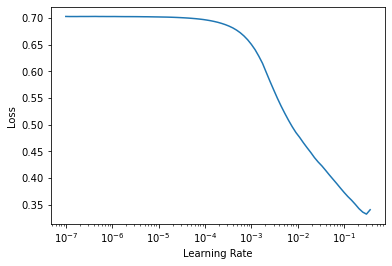

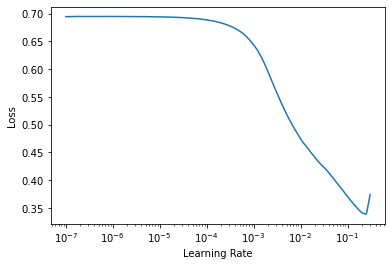

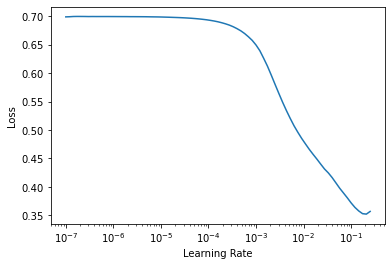

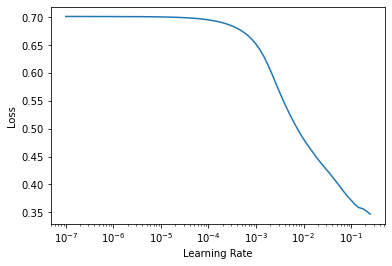

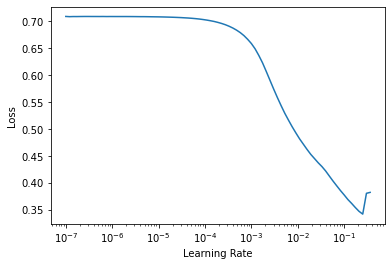

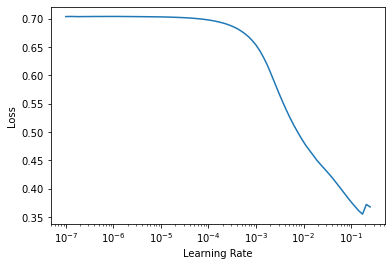

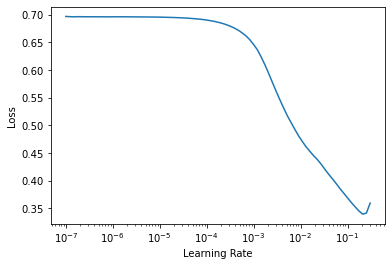

In [22]:
torch.cuda.empty_cache() 
best_valid = []

for i in range(FOLDS):
    print(i)
    dls = get_data(i) # Data
    #len(dls.train),len(dls.valid)
    #dls.show(5)

    #setup learner
    learn = tabular_learner(dls, layers=[512,512], loss_func=BCEWithLogitsLossFlat(), model_dir='/kaggle/working/')

    #get learning rate
    lr1, lr2 = learn.lr_find()
    print(round(lr2, 6))


    name = 'best_model_' + str(i) 
    cb = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks

    #train
    learn.fit_one_cycle(8, round(lr2, 6),cbs=cb)
    #load best model
    learn.load(name) 

    cb1 = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks
    learn.unfreeze()
    learn.fit_one_cycle(5,slice(1e-4),wd=0.2,cbs=cb1)
    #load best model
    learn.load(name) 

    cb2 = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5),wd=0.25,cbs=cb2)
    #load best model
    learn.load(name)

    losses = np.array(learn.recorder.values)
    best = np.argmin(losses[:,1])
    best_valid.append(losses[best,1])

    #export model
    learn.export('/kaggle/working/'+name+'.pkl') 
    
best_valid
    

In [23]:
best_valid

[0.01633511669933796,
 0.016791438683867455,
 0.016321059316396713,
 0.016611410304903984,
 0.016927549615502357,
 0.01564045622944832,
 0.016012703999876976,
 0.016455721110105515,
 0.016549410298466682,
 0.01692884974181652]

## 3. Predict

In [24]:
modelspath = Path("/kaggle/working/")

In [25]:
fold_preds = []
for i in range(FOLDS):
    learner = load_learner(modelspath/f'best_model_{i}.pkl')
    test_dl = learner.dls.test_dl(test_features)
    preds, _ = learner.get_preds(dl=test_dl)
    fold_preds += [preds]
preds = torch.stack(fold_preds)


In [26]:
mean_preds = preds.mean(0)
mean_preds[0]

In [28]:
submission = sub.copy()
submission[dep_var] = mean_preds
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0
submission['atp-sensitive_potassium_channel_antagonist'] = 0 # only appears once
submission['erbb2_inhibitor'] = 0 # only appears once

In [29]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000460,0.000776,0.001173,0.018678,0.024595,0.003519,0.001527,0.005075,0.000069,...,0.000434,0.000982,0.002451,0.001117,0.000291,0.000509,0.000307,0.001792,0.009819,0.001373
1,id_001897cda,0.000045,0.000248,0.001057,0.001208,0.001268,0.002231,0.001806,0.009295,0.011394,...,0.000127,0.000316,0.001583,0.000106,0.015058,0.000219,0.007486,0.000273,0.001528,0.002002
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000090,0.000127,0.001976,0.008686,0.004964,0.002384,0.001486,0.003234,0.000140,...,0.000157,0.000493,0.002177,0.047119,0.014163,0.000127,0.002343,0.000746,0.002019,0.003558
4,id_0027f1083,0.001046,0.000780,0.002300,0.015880,0.020365,0.002963,0.006339,0.001899,0.000171,...,0.000551,0.000674,0.005275,0.002412,0.000890,0.000428,0.000958,0.002095,0.000404,0.001101


In [30]:
submission.to_csv('submission.csv', index=False)

In [20]:
''' $xtra manual train/valid split
was manually split, replaced with k-fold
#temp split manually
#define train vs valid split
n_train = int(train_features.shape[0] *.8)

split_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])
train_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]
splits = (list(train_idx), list(valid_idx))

#preview
len(splits[0]), len(splits[1])

'''

'was manually split, replaced with k-fold\n#temp split manually\n#define train vs valid split\nn_train = int(train_features.shape[0] *.8)\n\nsplit_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])\ntrain_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]\nsplits = (list(train_idx), list(valid_idx))\n\n#preview\nlen(splits[0]), len(splits[1])\n\n'